In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster
import os
from google.colab import files # remove this if NOT using google colab

In [19]:
df = pd.read_json('data.json')
subset = df[["violation_code","latitude", "longitude", 'cuisine_description', 'camis',
             'dba', 'violation_description']]
df = subset.dropna(subset=['violation_code'])
df = df[(df['latitude'] != 0.0) & (df['longitude'] != 0.0)]
df.head()

,violation_code,latitude,longitude,cuisine_description,camis,dba,violation_description
1,09B,40.714270,-73.987501,Thai,50123243,Tiptara Thai,Thawing procedure improper.
2,02B,40.734890,-73.979822,Japanese,50001531,HANE SUSHI,Hot food item not held at or above 140º F.
3,04L,40.732070,-73.849148,Jewish/Kosher,50104791,CHO-SEN GARDEN,Evidence of mice or live mice in establishment...
4,20-06,40.830429,-73.910669,Latin American,50000796,EL NUEVO BOHIO RESTAURANT,Current letter grade or Grade Pending card not...
5,02B,40.837026,-73.942691,Pizza,41701789,FLACO'S PIZZERIA,Hot food item not held at or above 140º F.


In [20]:
df['dba'] = df['dba'].str.upper()

violationCount = df.groupby('dba')['violation_code'].count().reset_index(name='violation_count')

mostViolations = violationCount.sort_values(by='violation_count', ascending=False)

mostViolations.head(10)

,dba,violation_count
4872,DUNKIN,1126
15860,SUBWAY,722
15724,STARBUCKS,576
10833,MCDONALD'S,504
13629,POPEYES,384
2530,BURGER KING,278
4884,DUNKIN',259
8687,KENNEDY FRIED CHICKEN,258
6587,GOLDEN KRUST CARIBBEAN BAKERY & GRILL,242
4643,DOMINO'S,217


As we can see, it's mostly huge chains that have the most violations. Next I will group by location to see if this trend continues.

In [30]:
violationByRestaurant = df.groupby(['dba', 'latitude', 'longitude'])['violation_code'].count().reset_index(name='violation_count')

violationByRestaurant = violationByRestaurant.sort_values(by='violation_count', ascending=False)

violationByRestaurant.head(10)

,dba,latitude,longitude,violation_count
13762,MEE SUM CAFE,40.714861,-73.998200,38
8108,GAMMEEOK,40.747391,-73.986051,30
20051,SUN SAI GAI RESTAURANT,40.717139,-73.998795,28
16771,PIZZA TOWN,40.717841,-73.999737,26
1795,BAYARD BO KY RESTAURANT,40.715701,-73.998683,26
3784,CHAIRMAN SUN,40.744643,-73.953471,25
16551,PI GREEK BAKERIE,40.707159,-74.008353,25
21309,THE COPPOLA CAFE,40.732186,-74.001537,25
13761,MEE NOODLE SHOP,40.730864,-73.982923,25
4421,CINNABON/AUNTIE ANNE'S,40.742003,-73.993443,24


This is a good visual on the top 10 WORST locations when it comes to violations.Maybe compare these to reviews & see if they have negative reviews.

In [22]:
violationByRestaurant = violationByRestaurant.sort_values(by='violation_count', ascending=True)

violationByRestaurant.head(10)

,dba,latitude,longitude,violation_description,violation_count
4658,AURA COFFEE,40.676252,-73.962120,Current letter grade or Grade Pending card not...,1
4625,"AUNTIE ANNE'S PRETZELS, RED MANGO",40.701688,-74.011631,Food not protected from potential source of co...,1
4592,AUNTIE ANNE'S PRETZELS,40.710526,-74.009353,Current letter grade or Grade Pending card not...,1
4593,AUNTIE ANNE'S PRETZELS,40.710526,-74.009353,Establishment is not free of harborage or cond...,1
4594,AUNTIE ANNE'S PRETZELS,40.710526,-74.009353,Evidence of mice or live mice in establishment...,1
4595,AUNTIE ANNE'S PRETZELS,40.710526,-74.009353,Failure to post or conspicuously post healthy ...,1
4596,AUNTIE ANNE'S PRETZELS,40.710526,-74.009353,"Food contact surface not properly washed, rins...",1
4598,AUNTIE ANNE'S PRETZELS,40.710526,-74.009353,No hand washing facility in or adjacent to toi...,1
4599,AUNTIE ANNE'S PRETZELS,40.710526,-74.009353,Non-food contact surface or equipment made of ...,1
4600,AUNTIE ANNE'S PRETZELS,40.733840,-73.871577,Live roaches in facility's food or non-food area.,1


These are the bottom 10, dominated by Starbucks. May not want to use this, but if you do, maybe change from 10 to 25 or more.

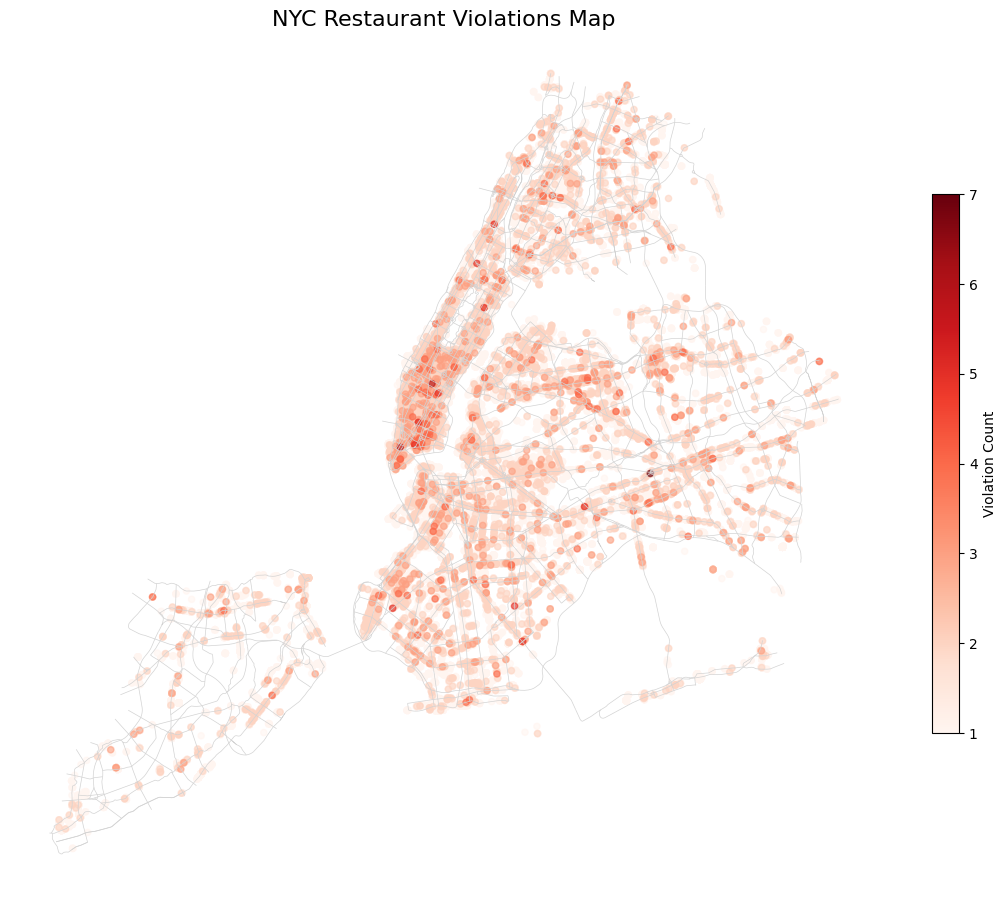

In [23]:
os.environ['SHAPE_RESTORE_SHX'] = 'YES'
newYork = gpd.read_file('/content/DCM_ArterialsMajorStreets.shp')
newYork.crs = 'epsg:2263'
newYork = newYork.to_crs(epsg=4326)

geometry = [Point(xy) for xy in zip(violationByRestaurant['longitude'], violationByRestaurant['latitude'])]
gdfViolations = gpd.GeoDataFrame(violationByRestaurant, geometry=geometry, crs='EPSG:4326')

fig, ax = plt.subplots(figsize=(14, 14))
newYork.plot(ax=ax, color='lightgray', linewidth=0.5)

gdfViolations.plot(
    ax=ax,
    column='violation_count',
    cmap='Reds',
    markersize=20,
    alpha=0.6,
    legend=True,
    legend_kwds={'label': "Violation Count", 'shrink': 0.5}
)

plt.title('NYC Restaurant Violations Map', fontsize=16)
plt.axis('off')
plt.show()

Above is a heatmap containing every restaurant in the dataset. We can use this one if y'all approve, but to me it looks a little messy and hard to read for us to use it.

In [24]:
top10000 = violationByRestaurant.sort_values('violation_count', ascending=False).head(10000)

mapTest = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
markerCluster = MarkerCluster().add_to(mapTest)

for _, row in top10000.iterrows():
    tooltip = f"{row['dba']}<br>Violations: {row['violation_count']}"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3 + min(row['violation_count'] / 10, 10),
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        tooltip=tooltip
    ).add_to(markerCluster)

mapTest.save('top_10000_map.html')
files.download('top_10000_map.html') # Remove this line if NOT using google colab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Above saves an HTML map with points. If you hover over the points, it will show you the restaurant name, and the amount of violations.

In [25]:
violationByCuisine = df.groupby('cuisine_description')['violation_code'].count().reset_index(name='violation_count')

restaurantsPerCuisine = df.groupby('cuisine_description')['dba'].nunique().reset_index(name='restaurant_count')

cuisineRatio = pd.merge(violationByCuisine, restaurantsPerCuisine, on='cuisine_description')

cuisineRatio['violations_per_restaurant'] = cuisineRatio['violation_count'] / cuisineRatio['restaurant_count']

cuisineRatio = cuisineRatio.sort_values(by='violations_per_restaurant', ascending=False)

cuisineRatio.head(10)

,cuisine_description,violation_count,restaurant_count,violations_per_restaurant
26,Donuts,1737,51,34.058824
38,Hamburgers,1448,86,16.837209
70,Salads,327,28,11.678571
10,Basque,10,1,10.000000
16,Chicken,2530,261,9.693487
64,Pancakes/Waffles,142,16,8.875000
71,Sandwiches,1793,229,7.829694
5,Australian,135,18,7.500000
8,Bangladeshi,440,61,7.213115
23,Creole,137,21,6.523810


There are a lot of cuisines with similar/exact names as each other. I am going to group all of the cuisines in to specific grouping to show a better idea of the actual ratio.

In [26]:
cuisineGroups = {
    'Chinese': 'Asian',
    'Chinese/Japanese': 'Asian',
    'Thai': 'Asian',
    'Southeast Asian': 'Asian',
    'Filipino': 'Asian',
    'Japanese': 'Asian',
    'Korean': 'Asian',
    'Bangladeshi': 'South Asian',
    'Indian': 'South Asian',
    'Pakistani': 'South Asian',
    'Indonesian': 'Asian',
    'Asian/Asian Fusion': 'Asian',
    'Fusion': 'Asian Fusion',

    'Mexican': 'Latin',
    'Tex-Mex': 'Latin',
    'Latin American': 'Latin',
    'Peruvian': 'Latin',
    'Caribbean': 'Latin',
    'Creole': 'Latin',
    'Chilean': 'Latin',

    'Middle Eastern': 'Middle Eastern',
    'Egyptian': 'Middle Eastern',
    'Turkish': 'Middle Eastern',
    'Iranian': 'Middle Eastern',
    'Afghan': 'Middle Eastern',
    'Moroccan': 'Middle Eastern',

    'French': 'European',
    'Greek': 'European',
    'Portuguese': 'European',
    'Spanish': 'European',
    'Eastern European': 'European',
    'Basque': 'European',
    'English': 'European',
    'Russian': 'European',

    'African': 'African',

    'Pizza': 'Fast Food',
    'Hamburgers': 'Fast Food',
    'Hotdogs/Pretzels': 'Fast Food',
    'Chicken': 'Fast Food',
    'Barbecue': 'Fast Food',
    'Sandwiches': 'Fast Food',
    'Sandwiches/Salads/Mixed Buffet': 'Fast Food',

    'Donuts': 'Bakery/Breakfast',
    'Pancakes/Waffles': 'Bakery/Breakfast',
    'Bagels/Pretzels': 'Bakery/Breakfast',
    'Bakery Products/Desserts': 'Bakery/Breakfast',
    'Frozen Desserts': 'Bakery/Breakfast',

    'Coffee/Tea': 'Beverage',
    'Juice, Smoothies, Fruit Salads': 'Beverage',

    'Soul Food': 'Southern',
    'Cajun': 'Southern',

    'Vegan': 'Health-Conscious',
    'Salads': 'Health-Conscious',
    'Soups': 'Health-Conscious',

    'Australian': 'Western',
    'Californian': 'Western'
}

Make a note that "Other" may include restaurants that fit into other categories. If you want to try and fix this, you can, I can only get the top 60 to show, so I'm not sure which cuisines I'm missing.

In [27]:
cuisineRatio['cuisine_group'] = cuisineRatio['cuisine_description'].map(cuisineGroups).fillna('Other')

grouped = cuisineRatio.groupby('cuisine_group').agg({
    'violation_count': 'sum',
    'restaurant_count': 'sum'
}).reset_index()

grouped['violations_per_restaurant'] = grouped['violation_count'] / grouped['restaurant_count']

grouped = grouped.sort_values(by='violations_per_restaurant', ascending=False)

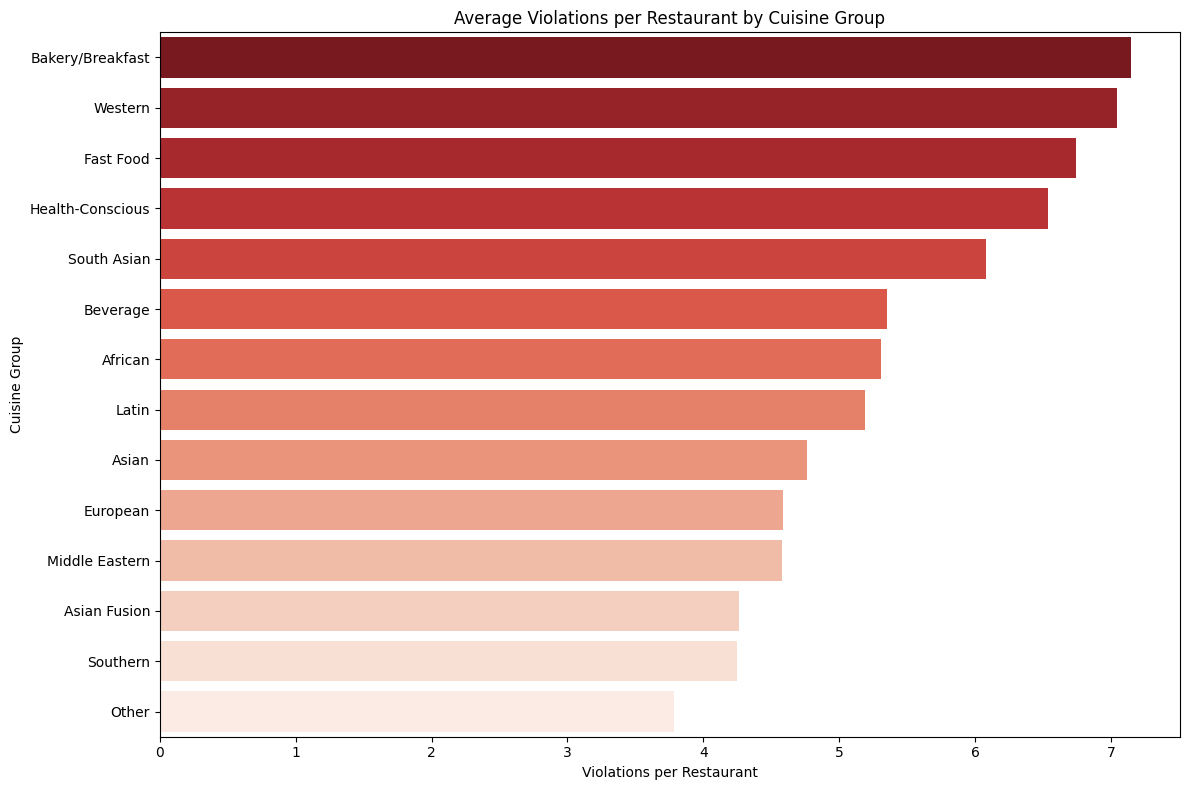

In [28]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=grouped,
    x='violations_per_restaurant',
    y='cuisine_group',
    hue='cuisine_group',
    palette='Reds_r',
    dodge=False,
    legend=False
)
plt.title('Average Violations per Restaurant by Cuisine Group')
plt.xlabel('Violations per Restaurant')
plt.ylabel('Cuisine Group')
plt.tight_layout()
plt.show()

This is a great view of the types of cuisines and how they compare to each other when it comes to violations.

In [29]:
df['cuisine_group'] = df['cuisine_description'].map(cuisineGroups).fillna('Other')

violationCount = df.groupby(['cuisine_group', 'violation_code', 'violation_description']).size().reset_index(name='count')

topViolations = violationCount.sort_values('count', ascending=False) \
                              .drop_duplicates(subset='cuisine_group')

topViolations = topViolations.sort_values('cuisine_group').reset_index(drop=True)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

topViolations[['cuisine_group', 'violation_code', 'violation_description', 'count']]

,cuisine_group,violation_code,violation_description,count
0,African,10F,"Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",50
1,Asian,10F,"Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",1929
2,Asian Fusion,08A,"Establishment is not free of harborage or conditions conducive to rodents, insects or other pests.",29
3,Bakery/Breakfast,10F,"Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",1060
4,Beverage,10F,"Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",1120
5,European,10F,"Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",482
6,Fast Food,10F,"Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",1671
7,Health-Conscious,10F,"Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",73
8,Latin,10F,"Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",1464
9,Middle Eastern,10F,"Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.",144


This table shows the most common violation for each cuisine. 10F is the most common violation overall.

In [43]:
top10 = violationByRestaurant.head(10)[['dba', 'latitude', 'longitude', 'violation_count']]
top10['original_index'] = range(len(top10))

top10Violations = df.merge(top10, on=['dba', 'latitude', 'longitude'])

violationCount = top10Violations.groupby(['dba', 'latitude', 'longitude', 'violation_code']).size().reset_index(name='count')

violationCount = violationCount.merge(top10[['dba', 'latitude', 'longitude', 'original_index']], on=['dba', 'latitude', 'longitude'], how='left')

violationCount = violationCount.sort_values(['original_index', 'count'], ascending=[True, False])

mostCommonViolationPerRestaurant = violationCount.groupby(['dba', 'latitude', 'longitude']).first().reset_index()

mostCommonViolationPerRestaurant = mostCommonViolationPerRestaurant.sort_values('original_index').reset_index(drop=True)
mostCommonViolationPerRestaurant = mostCommonViolationPerRestaurant.drop(columns=['original_index'])
mostCommonViolationPerRestaurant

,dba,latitude,longitude,violation_code,count
0,MEE SUM CAFE,40.714861,-73.998200,02G,5
1,GAMMEEOK,40.747391,-73.986051,10F,7
2,SUN SAI GAI RESTAURANT,40.717139,-73.998795,08A,4
3,PIZZA TOWN,40.717841,-73.999737,02G,4
4,BAYARD BO KY RESTAURANT,40.715701,-73.998683,06C,4
5,CHAIRMAN SUN,40.744643,-73.953471,02G,3
6,PI GREEK BAKERIE,40.707159,-74.008353,02G,4
7,THE COPPOLA CAFE,40.732186,-74.001537,08A,4
8,MEE NOODLE SHOP,40.730864,-73.982923,04L,4
9,CINNABON/AUNTIE ANNE'S,40.742003,-73.993443,08C,3
